# The goal of this notebook is to complete the `Computational Exploration` found in Chapter 5 (Figure 5.14-15)

As always our first step is to start the `qt event loop`

In [1]:
%gui qt

Next we need to import `Napari` and the `nbscreenshot` tool and open the `viewer`.

In [2]:
import napari
from napari.utils import nbscreenshot
import numpy as np
# Create an empty viewer
viewer = napari.Viewer()

## You can drag-n-drop the folder into `Napari` and it will properly open it as a timeseries

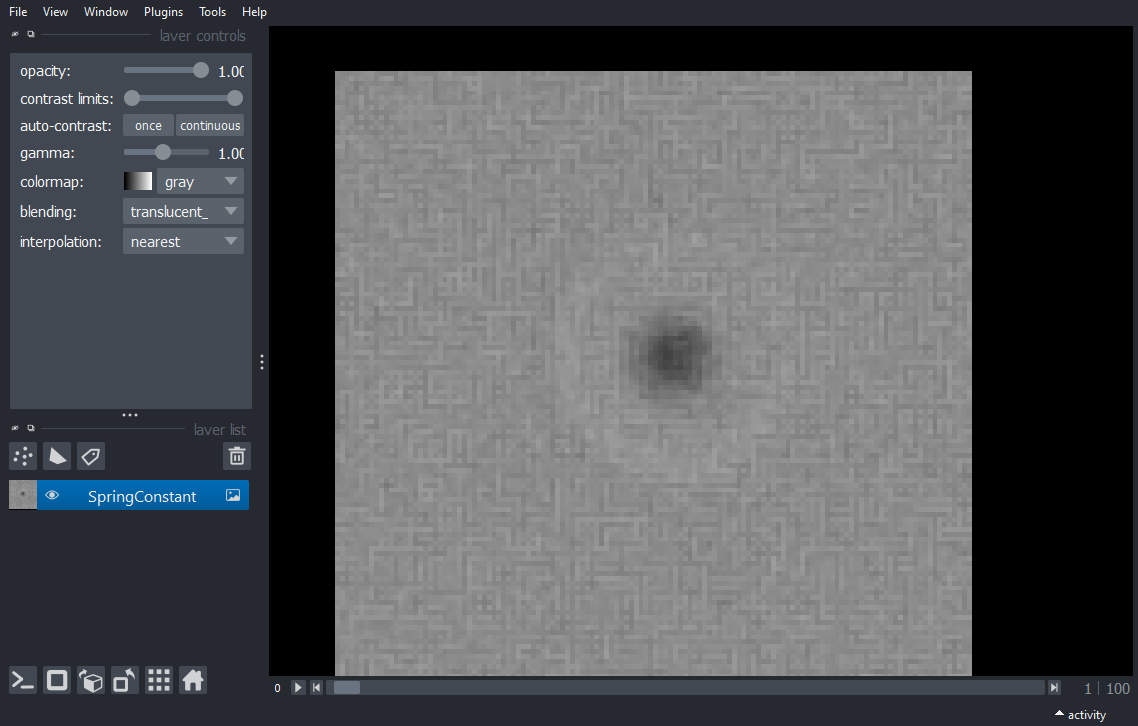

In [4]:
nbscreenshot(viewer)

## But, is there a way to do that programatically?

Depending on where you have your folder.

In [101]:
viewer.open('data/SpringConstant/*.tif', name='Bead')
bead = viewer.layers['Bead'].data


<Image layer 'Normalized Bead' at 0x1fe85fe3b80>

The bead is a dark spot in the center. We might be better off trying to invert this and then normalizing so it ranges from 0-1.

In [105]:
ibead = 1/bead
viewer.add_image(ibead,name='Inverted Bead')
bead_normal = (ibead-np.min(ibead))/(np.max(ibead)-np.min(ibead))
viewer.add_image(bead_normal, name='Normalized Bead')


<Image layer 'Normalized Bead' at 0x1fe85fb32e0>

# Ok, but how do we find the center of the bead?

Let's start with a single frame.

In [107]:
single = bead_normal[0]
viewer.add_image(single)

<Image layer 'single' at 0x1fe8175a700>

In [108]:
import numpy as np
peak = np.unravel_index(np.argmax(single),single.shape)
viewer.add_points(peak, size=2, face_color='lightblue')

<Points layer 'Points' at 0x1fe85db4ac0>

### Using a list comprehension enables us to do this over time.

In [145]:
peaks=[np.unravel_index(np.argmax(single), single.shape) for single in bead_normal]

### The dimensions are wrong though so they just populate all the frames.

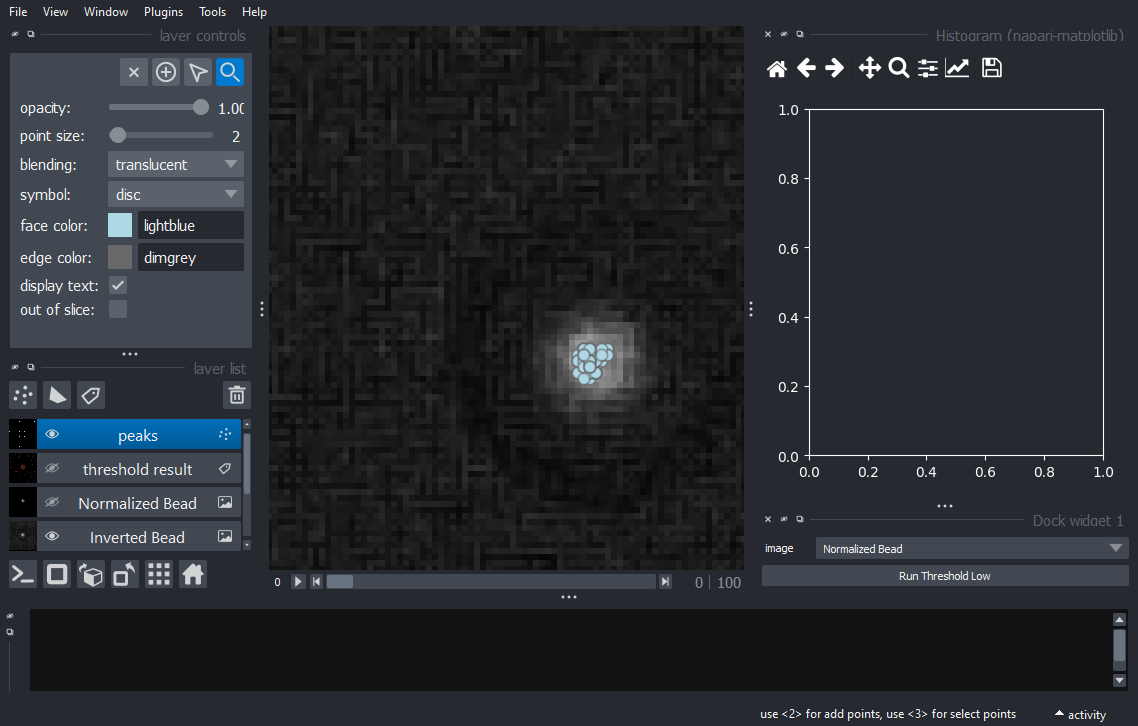

In [146]:
viewer.add_points(peaks, size=2, face_color='lightblue',name='peaks')
nbscreenshot(viewer)

## We need to use a bit of pythonfu to add the third dimension to these coordinates.
Is there a better way? Probably. Do I know a better way? No.

In [147]:
ind = np.arange(len(peaks))
coords = np.array([(ind, peaks[ind][0], peaks[ind][1]) for ind in ind])
viewer.layers['peaks'].visible=False
viewer.add_points(coords, name='Max Values', size=2, face_color='lightblue')

<Points layer 'Max Values' at 0x1fe85abaaf0>

## That _**works**_ but it is not good enough actually. We need sub-pixel accuracy to make this worth our while.

## `Skimage` is the go-to for all things image analysis.

[Feature module](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature)

In [265]:
from skimage import filters
from skimage import measure
from skimage import morphology

Can we try the same automatic thresholding?

In [148]:
foreground = ibead >= filters.threshold_li(ibead)
viewer.add_labels(foreground, opacity=0.4)

<Labels layer 'foreground' at 0x1fe85abaee0>

Not really...

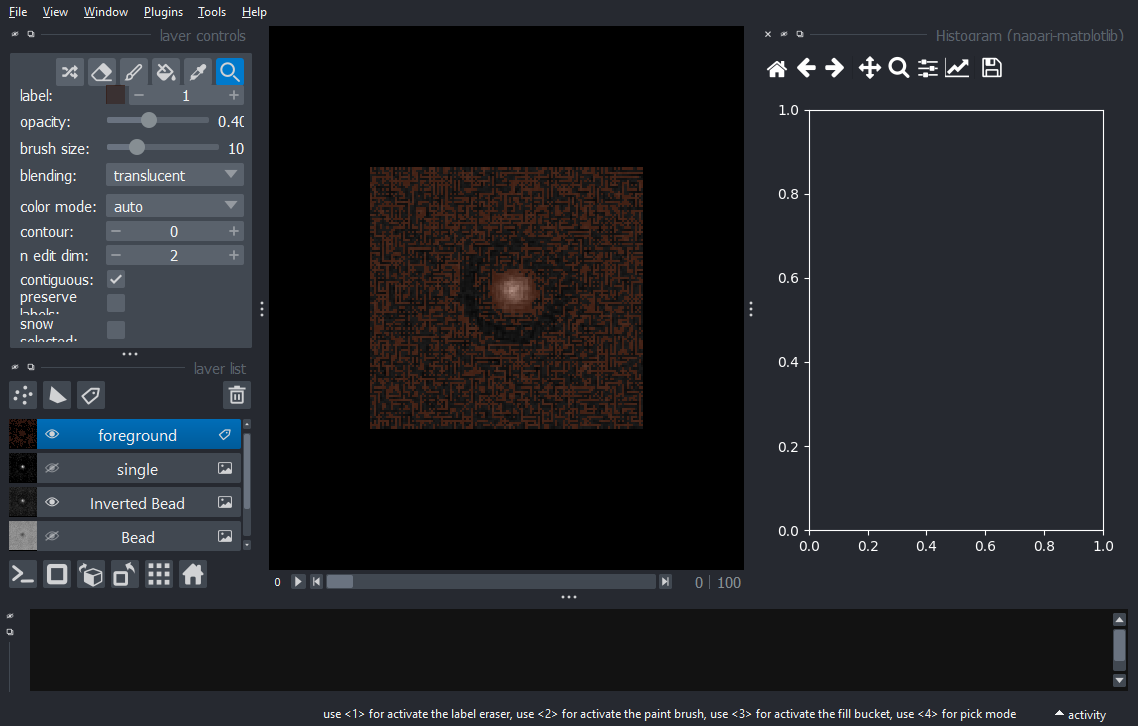

In [22]:
nbscreenshot(viewer)

## How about our widget we created before?

In [251]:
from magicgui import magicgui
from napari.types import LabelsData
from napari.layers import Image

@magicgui(threshold={'widget_type': 'FloatSlider', 'value': 0.2,'min': 0, 'max': 1}, auto_call=True)
def threshold_wdg(image: Image, threshold: float) -> LabelsData:
    """Threshold an image and return a mask."""
    return image.data > threshold


def update_range():
    threshold_wdg.threshold.max = threshold_wdg.image.value.contrast_limits[1]
    threshold_wdg.threshold.value = threshold_wdg.threshold.max/2

threshold_wdg._result_name = 'Threshold Result';
threshold_wdg.image.changed.connect(update_range);
viewer.window.add_dock_widget(threshold_wdg,name='Threshold Intensity');

threshold_wdg();  # "call the widget" to call the function.
# Normally this would be caused by some user UI interaction


## Convert the threshold result to a layer and find the centroid.

In [400]:
data_processed = morphology.remove_small_holes(viewer.layers['Threshold Result'].data, 60)
data_processed = morphology.remove_small_objects(
    data_processed, min_size=50).astype(bool)
viewer.layers['Threshold Result'].data = data_processed
label=measure.label(data_processed)
intensity_img=viewer.layers['Normalized Bead'].data
viewer.add_labels(label);

label [1]


c:\Apps\anaconda3\envs\napari-env\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [399]:
smooth = filters.gaussian(intensity_img,sigma=1)
viewer.add_image(smooth,name='Gaussian blur 1')

Gaussian blur 1


<Image layer 'Gaussian blur 1' at 0x1fe85d86670>

In [401]:
rprops = [measure.regionprops(label, int_img)
          for label, int_img in zip(label, intensity_img)]
num_labels = len(rprops)
centroids=np.empty((num_labels,3))    
for i in range(num_labels):
    centroids[i,:] = [i,rprops[i][0]['centroid'][0],rprops[i][0]['centroid'][1]]

viewer.add_points(centroids, name='Centroids', size=2, face_color='lightblue');


Centroids [1]


In [461]:
import trackpy as tp
import matplotlib.pyplot as plt
f = tp.locate(intensity_img[0],31,minmass=10)


,y,x,mass,size,ecc,signal,raw_mass,ep
1,58.028673,67.93829,45.295369,4.957787,0.030936,0.530732,143.48274,NaN


In [475]:
features = [tp.locate(frame,31,minmass=10) for frame in intensity_img]

[           y         x       mass      size       ecc    signal   raw_mass  ep
 1  58.028673  67.93829  45.295369  4.957787  0.030936  0.530732  143.48274 NaN,
            y          x       mass      size       ecc    signal    raw_mass  \
 1  57.830303  68.579161  47.839281  4.930858  0.016886  0.557236  145.947072   
 
    ep  
 1 NaN  ,
            y          x      mass     size       ecc  signal    raw_mass  ep
 2  58.050389  67.216318  47.50168  4.87983  0.018298  0.5641  147.743569 NaN,
            y          x       mass      size       ecc    signal    raw_mass  \
 2  57.092673  68.374728  47.513759  4.911278  0.023253  0.549329  146.781735   
 
    ep  
 2 NaN  ,
            y          x       mass      size       ecc    signal    raw_mass  \
 1  57.150476  68.261945  47.415872  4.877361  0.027455  0.532927  146.254747   
 
    ep  
 1 NaN  ,
            y          x       mass      size       ecc    signal    raw_mass  \
 0  57.528178  68.082657  47.221098  4.869787  0.015

Now that we have the centroids tracked with sub-pixel accuracy. We can proceed to calculate the mean squared displacement.

In [402]:
xcoords=centroids[:,1]
ycoords=centroids[:,2]
x_mean = xcoords.mean()
y_mean = ycoords.mean()
MSDx = np.mean((xcoords-x_mean)**2)
MSDy = np.mean((ycoords-y_mean)**2)

## This would give us the MSD in the units of pixels^2.
The cooresponding size in pixels is using 100micron in 1028 pixels.

In [403]:
factor = (100/1028)**2
MSDx_micron = MSDx*factor
MSDy_micron = MSDy*factor

## The last conversion we need to know that it was performed at 25C
Therfore, kbT = 4E-3 um pN

Spring constant x (kx): kbt/ MSDxum
(ky) = kbt/MSDyum

In [404]:
kx = 4E-3/MSDx_micron
ky = 4E-3/MSDy_micron

print('Spring Constant in X direction: ',kx ,' pN*um')
print('Spring Constant in Y direction: ', ky,' pN*um')

Spring Constant in X direction:  4.866764699106082  pN*um
Spring Constant in Y direction:  4.776728869236388  pN*um


## We can plot the displacement of the bead as a function of time.

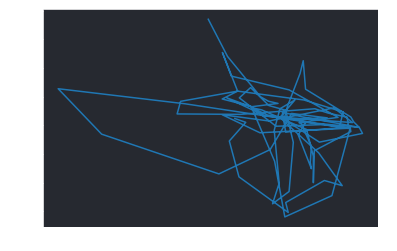

In [405]:
import matplotlib.pyplot as plt
plt.plot(ycoords,xcoords)